2025-04-09 05:22:05.506966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Input shape: (10000, 1280), Target shape: (10000, 1024)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
Total params: 3410944 (13.01 MB)
Trainable params: 3410944 (13.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
141/141 [==============================] - 6s 35ms/step - loss: 1.0255 - mae: 0.8060 - val_loss: 1.0012 - val_mae: 0.7982
Epoch 2/20
141/141 [==============================] - 4s 31ms/step - loss: 1.0000 - mae: 0.

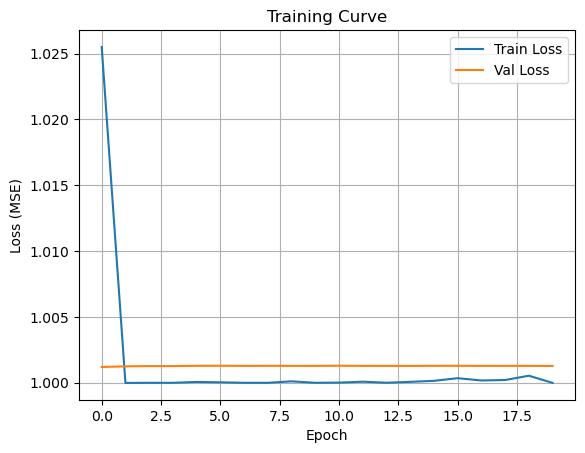

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ------------------------------
# Parameters
# ------------------------------
num_aps = 64            # Number of distributed APs
num_ues = 8             # Number of UEs
pilot_length = 10       # Length of pilot sequence
num_samples = 10000     # Number of training samples
snr_db = 10             # Signal-to-noise ratio in dB

# ------------------------------
# Data Generation
# ------------------------------

def generate_data(num_samples):
    X = []
    Y = []
    snr = 10**(snr_db / 10)

    for _ in range(num_samples):
        # True channel (H): num_aps x num_ues
        h_real = np.random.randn(num_aps, num_ues)
        h_imag = np.random.randn(num_aps, num_ues)
        H = h_real + 1j * h_imag

        # Pilot symbols (S): num_ues x pilot_length
        S = np.exp(1j * 2 * np.pi * np.random.rand(num_ues, pilot_length))

        # Received signal Y = H * S + Noise
        noise_real = np.random.randn(num_aps, pilot_length)
        noise_imag = np.random.randn(num_aps, pilot_length)
        noise = (noise_real + 1j * noise_imag) / np.sqrt(2 * snr)

        Y_rx = H @ S + noise

        # Inputs: real and imag of received signal
        x_input = np.stack([Y_rx.real, Y_rx.imag], axis=-1)
        x_input = x_input.reshape(-1)

        # Targets: real and imag of channels
        y_target = np.stack([H.real, H.imag], axis=-1)
        y_target = y_target.reshape(-1)

        X.append(x_input)
        Y.append(y_target)

    return np.array(X), np.array(Y)

X_train, y_train = generate_data(num_samples)
X_test, y_test = generate_data(1000)

print(f"Input shape: {X_train.shape}, Target shape: {y_train.shape}")

# ------------------------------
# Build Neural Network
# ------------------------------

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(y_train.shape[1])  # Output dimension
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# ------------------------------
# Train Model
# ------------------------------

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

# ------------------------------
# Evaluate
# ------------------------------

loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

# ------------------------------
# Visualization
# ------------------------------

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()
